In [1]:
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
from path import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
#import plotly.graph_objs as go
import plotly.graph_objects as go
cf.go_offline()
cf.set_config_file(offline = True)
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

# Read the trading_signals.csv file into a Pandas DataFrame

# Set the date column as the DateTimeIndex

In [2]:

data_path = Path("bitcoin_2010-8-16_2021-10-6.csv")
df = pd.read_csv(
    data_path,
    index_col="Date",
    infer_datetime_format=True,
    parse_dates=True
)

# Review the DataFrame

In [4]:

df.sort_values(by=['Date'], inplace=True, ascending=True)


In [5]:


df.head()



,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2010-08-16,0.07,0.07,0.07,0.07,0,0
2010-08-17,0.07,0.07,0.07,0.07,0,0
2010-08-18,0.07,0.07,0.07,0.07,0,0
2010-08-19,0.07,0.07,0.07,0.07,0,0
2010-08-20,0.07,0.07,0.07,0.07,0,0


## EXPLORATORY DATA ANALYSIS

# Check if there is any missing values

In [6]:
df.isnull().values.any()

False

## Describe the Data Set

In [7]:


df.describe()



,Open,High,Low,Close,Volume,Market Cap
count,3979.000000,3979.000000,3979.000000,3979.000000,3.979000e+03,3.979000e+03
mean,6021.571407,6194.930148,5836.781990,6035.582566,1.148943e+10,1.092203e+11
std,11664.263409,12016.305829,11281.014648,11690.986417,2.602466e+10,2.181235e+11
min,0.060000,0.060000,0.060000,0.060000,0.000000e+00,0.000000e+00
25%,125.375000,127.370000,122.105000,125.405000,0.000000e+00,1.384740e+09
50%,625.970000,638.650000,616.610000,626.430000,6.529633e+07,9.128638e+09
75%,7439.370000,7589.780000,7294.540000,7449.175000,7.199873e+09,1.308160e+11
max,63545.120000,64816.100000,62090.500000,63528.480000,2.121515e+11,1.184937e+12


In [8]:
df_close = df['Close']


In [9]:
df_close.head()

Date
2010-08-16    0.07
2010-08-17    0.07
2010-08-18    0.07
2010-08-19    0.07
2010-08-20    0.07
Name: Close, dtype: float64

# Price change between 2010 and 2021

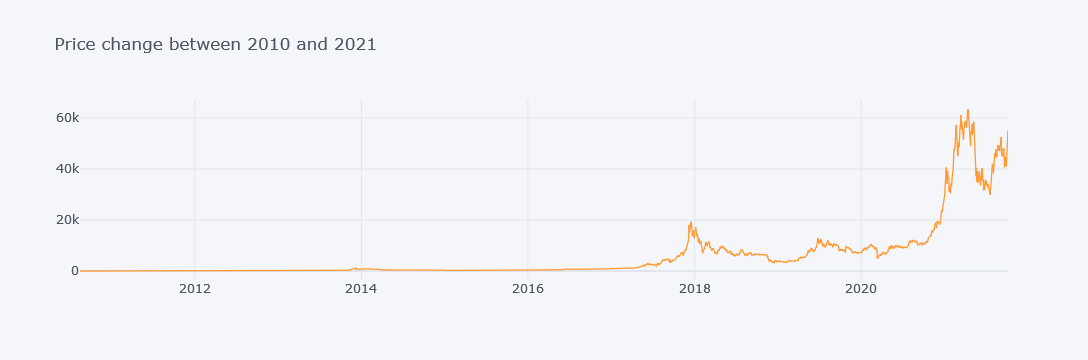

In [10]:
df_close.iplot(title = 'Price change between 2010 and 2021')

## Calculate daily return change

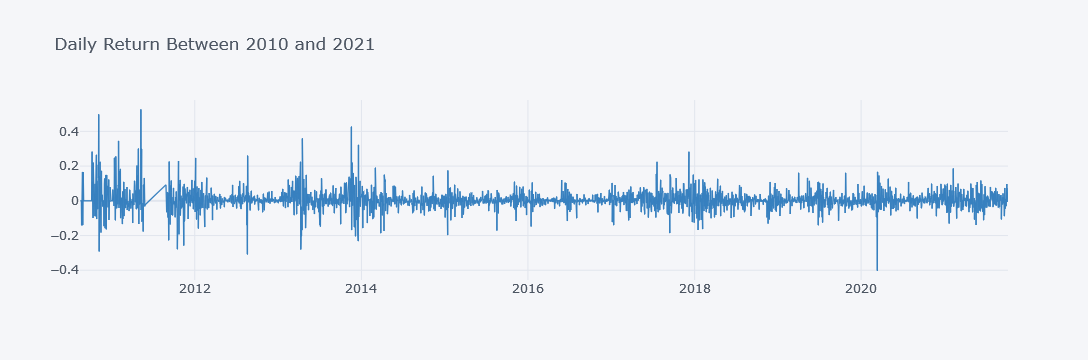

In [11]:
ret = df_close.pct_change()
ret.iplot(colors = 'Blue',title = 'Daily Return Between 2010 and 2021')



## MACHINE LEARNING ALGORITMS
## DATA PREPERATION
## Normalize the Data


# First thing we need to do is to normalize the data with sklearn's MinMaxScaler function. We created a function for it.
# The data will be scaled between 0 - 1

In [12]:

def normalize_featuresDF(df):
    """
    We created to normalize df data - range between 0-1
    args:
        df : the data we pulled up from csv file for the stock
    return:
        normalized_features_df : data after it is normalized
    
    """
    scaler = MinMaxScaler()
    feature_columns = df.columns
    feature_minmax_data = scaler.fit_transform(df)
    normalized_features_df = pd.DataFrame(columns=feature_columns, data=feature_minmax_data, index=df.index)
    
    
    return normalized_features_df

## Split the data into Train, Test and Validation sets

In [13]:
def split_ValidationSet(features_df, target_df, length=90):
    """
    method is to separate validation set from the complete df
    args:
        features_df: full features_df
        target_df :  full target_df
        length: prediction length
    returns : 
        validation_x : returns features validations sets
        validation_y : returns target validations sets
    """
    #need to shift target array because we are prediction n + 1 days price
    target_df = target_df.shift(-1)
    #split validation set . i am spliting 10% latest data for validation.
    #target
    validation_y = target_df[-length:-1]
    validation_x = features_df[-length:-1]
    
    return validation_x, validation_y

#Now get final_features_df and final_target_df by excluding validation set
def split_Final_df(normalized_features_df, target_df, v_length=90):
    """
    This method will be having remaining data after the validation set.
    args:
        features_df: normalized features_df
        target_df: complete target_df
        v_length: validation set length
    return: 
        final_features_df : set of feature df excluding validation set
        final_target_df : set of target df excluding validation set
    """
    final_features_df = normalized_features_df[:-v_length]
    final_target_df = target_df[:-v_length]
    
    return final_features_df, final_target_df

## Train and Test split - Timeseries split

# Split final set into training and testing sets
# Splitting training and testing set using sklearn's TimeSeries split

In [14]:

def split_Train_Test_DF(final_features_df, final_target_df, n_splits=10):
    """
    Using sklearn's timeseries split to split the training and testing sets
    args:
        final_features_df: features_df after splitting validation set
        final_target_df: target_df after splitting validation set
    
    return: 
        x_train : traing feature set
        y_train : training target set
        x_test : testing feature set
        y_test : testing target set
    """
    ts_split = TimeSeriesSplit(n_splits)
    for train_index, test_index in ts_split.split(final_features_df):
        x_train, x_test = final_features_df[:len(train_index)], final_features_df[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = final_target_df[:len(train_index)].values.ravel(), final_target_df[len(train_index): (len(train_index)+len(test_index))].values.ravel()
        
    return x_train, y_train, x_test, y_test

## Visualizing the datasets

In [15]:
def DataSet_Graph():
    """
    
    Chart shows 2 different sets(Train,Test,Validation) into single plot
    Since it is time series data, it shouldnot be mixed 
    """
    t=y_test.astype(np.float)
    v = target_df[-90:-1].values.ravel()
    plt.figure(figsize = (20,10))
    plt.plot(y_train, label='trainning_set')
    plt.plot([None]*len(y_train) + [x for x in t], label='test_set')
    plt.plot([None]*(len(y_train)+len(t)) + [x for x in v], label='validation_set')
    plt.xlabel('Days',fontsize = 18)
    plt.ylabel('Price',fontsize = 18)
    plt.title('Split dataset into training/validation/test set',fontsize = 20)
    plt.legend()



## Implementing model prediction and evaluation
## Method for validating result with evaluation metrics
## Evaluate the benchmark model and solution model with validate data set

In [16]:

def model_validateResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    args:
        model : the model is to validate
        model_name: name of the model
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """

    model = model(x_train, y_train, validation_x)
    prediction = model.predict(validation_x)
    RMSE_Score = np.sqrt(mean_squared_error(validation_y, prediction))
    R2_Score = r2_score(validation_y, prediction)
    
    #trendline for actual vs prediction

    plt.figure(figsize = (23,10))
    plt.plot(validation_y.index, prediction, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='green', markersize=8,label = 'Prediction data')
    plt.plot(validation_y.index, validation_y, color='red', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='red', markersize=8,label = 'Actual data')
    plt.plot(figsize = (23,10))
    plt.ylabel('Price',fontsize = 20)
    plt.xlabel('Date',fontsize = 20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual',fontsize = 20)
    plt.legend(loc='upper left')
    plt.show()
    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score)
    return RMSE_Score, R2_Score




#Method to evaluate the final model with testing data set
def bestModel_validateResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    args:
        model : the model is to validate
        model_name: name of the model
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """ 
    #I am giving testing set for the evaluation 
    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)
    
    RMSE_Score = np.sqrt(mean_squared_error(y_test, prediction))
    R2_Score = r2_score(y_test, prediction)
    plt.figure(figsize = (23,10))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(model_name + 'Prediction Vs Actual',fontsize = 20)
    plt.plot(y_test, label='test data')
    plt.plot(prediction, label='prediction')
    plt.xlabel('Days',fontsize = 20)
    plt.ylabel('Price',fontsize = 20)
    plt.legend();
    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score) 
    return RMSE_Score, R2_Score



def value_Compare(model):
    """
    this method is used to create final data frame using testing value with predicted value.
    args:
        model : trained model
    return : 
        df : df with test value and predicted value
    """
    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)
    col1 = pd.DataFrame(y_test, columns=['True_value'])
    col2 = pd.DataFrame(prediction, columns = ['Predicted_value'])
    df = pd.concat([col1, col2], axis=1)
    return df



## Build Models with functions
## Decision Tree Regressor(DTR)

# Modeling DecisionTreeRegressor with default parameters

In [17]:


def model_Decision_Tree_Regressor(x_train, y_train,validation_x, random_state=0):
    """
    Method is to model DecisionTreeRegressor
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
        random_state : default parameter it controls the randomness of the estimater
    
    return: 
        model : returns the trained model
        
    """
    #initialize DTR
    dtr = DecisionTreeRegressor(random_state=0)   
    #fit the data
    model = dtr.fit(x_train, y_train)
    
    return model

## Support Vector Regressor(SVR)

In [19]:
def model_SVR(x_train, y_train, validation_x):
    
    """
    This method uses svr algorithm to trian the data.
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
    return:
        model : returns the trained model
    """
    svr_model = SVR(kernel='linear')
    model = svr_model.fit(x_train, y_train)
    return model

def model_SVRTuning(x_train, y_train, validation_x):
    """
    This method uses svr algorithm to trian the data.
    Using different set of C and epsilon.
    Using GridSearchCV to select best hyperparameters
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
    return:
        model : returns the trained model
    """
    hyperparameters_linearSVR = {
        'C':[0.5, 1.0, 10.0, 50.0, 100.0, 120.0,150.0, 300.0, 500.0,700.0,800.0, 1000.0],
        'epsilon':[0, 0.1, 0.5, 0.7, 0.9],
    }
    
    grid_search_SVR_feat = GridSearchCV(estimator=model_SVR(x_train, y_train, validation_x),
                           param_grid=hyperparameters_linearSVR,
                           cv=TimeSeriesSplit(n_splits=10),
    )

    model = grid_search_SVR_feat.fit(x_train, y_train)
    #print(grid_search_SVR_feat.best_params_)
    
    return model



## Lasso amd Ridge Models

In [233]:

"""
    This method uses to train the data.
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
    return:
        model : returns the trained model
    """

'\n    This method uses to train the data.\n    args:\n        x_train : feature training set\n        y_train : target training set\n        validation_x : validation feature set\n    return:\n        model : returns the trained model\n    '

In [20]:
def model_Lasso(x_train, y_train, validation_x):
    lasso_clf = LassoCV(n_alphas=1000, max_iter=3000, random_state=0)
    model = lasso_clf.fit(x_train,y_train)
#   prediction = model.predict(validation_x)
    return model


def model_Ridge(x_train, y_train, validation_x):
    ridge_clf = RidgeCV(gcv_mode='auto')
    model = ridge_clf.fit(x_train,y_train)
    
#   prediction = ridge_model.predict(validation_x)
    return model

## Implimentation
## Selecting features df and target df
## Normalizing the data¶
#  Normalizing features df

In [22]:

normalized_features_df = normalize_featuresDF(df)
target_df = df[['Close']]

# Get shape of the features and target data

In [23]:

print("feature_df has (rows, columns) : {} ".format(normalized_features_df.shape))
print("target_df has (rows, columns) : {} ".format(target_df.shape))

feature_df has (rows, columns) : (3979, 6) 
target_df has (rows, columns) : (3979, 1) 


In [24]:
normalized_features_df

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2010-08-16,1.573686e-07,1.542828e-07,1.610554e-07,1.574099e-07,0.000000,0.000000
2010-08-17,1.573686e-07,1.542828e-07,1.610554e-07,1.574099e-07,0.000000,0.000000
2010-08-18,1.573686e-07,1.542828e-07,1.610554e-07,1.574099e-07,0.000000,0.000000
2010-08-19,1.573686e-07,1.542828e-07,1.610554e-07,1.574099e-07,0.000000,0.000000
2010-08-20,1.573686e-07,1.542828e-07,1.610554e-07,1.574099e-07,0.000000,0.000000
...,...,...,...,...,...,...
2021-10-02,7.576908e-01,7.443818e-01,7.644942e-01,7.510097e-01,0.285711,0.760010
2021-10-03,7.502442e-01,7.585058e-01,7.604659e-01,7.578355e-01,0.224211,0.762886
2021-10-04,7.583058e-01,7.625538e-01,7.570397e-01,7.740898e-01,0.286299,0.765162


In [241]:
target_df

,Close
Date,
2010-08-16,0.07
2010-08-17,0.07
2010-08-18,0.07
2010-08-19,0.07
2010-08-20,0.07
...,...
2021-10-02,47710.52
2021-10-03,48144.15
2021-10-04,49176.76


## Splitting train, test, validation sets

# Splitting validation sets from the final features and target df

In [25]:

validation_x, validation_y = split_ValidationSet(normalized_features_df, target_df)

In [26]:
print("validation_x has (rows, columns) : {} ".format(validation_x.shape))
print("validation_y has (rows, columns) : {} ".format(validation_y.shape))

validation_x has (rows, columns) : (89, 6) 
validation_y has (rows, columns) : (89, 1) 


# Splitting train and test set from validation set

In [27]:

final_features_df, final_target_df = split_Final_df(normalized_features_df, target_df)

In [28]:
print("final_features_df has (rows, columns) : {} ".format(final_features_df.shape))
print("final_target_df has (rows, columns) : {} ".format(final_target_df.shape))

final_features_df has (rows, columns) : (3889, 6) 
final_target_df has (rows, columns) : (3889, 1) 


## Splitting Train and Test using Skleans TimeSeriesSplit

# Splitting train and test

In [29]:

x_train, y_train, x_test, y_test = split_Train_Test_DF(final_features_df, final_target_df)

In [30]:
print("Shape of training sets x_train : {}, y_train : {}".format(x_train.shape, y_train.shape))
print("Shape of testing sets x_train : {}, y_train : {}".format(x_test.shape, y_test.shape))

Shape of training sets x_train : (3536, 6), y_train : (3536,)
Shape of testing sets x_train : (353, 6), y_train : (353,)


# Visualizing the train, test and validation sets in single plot


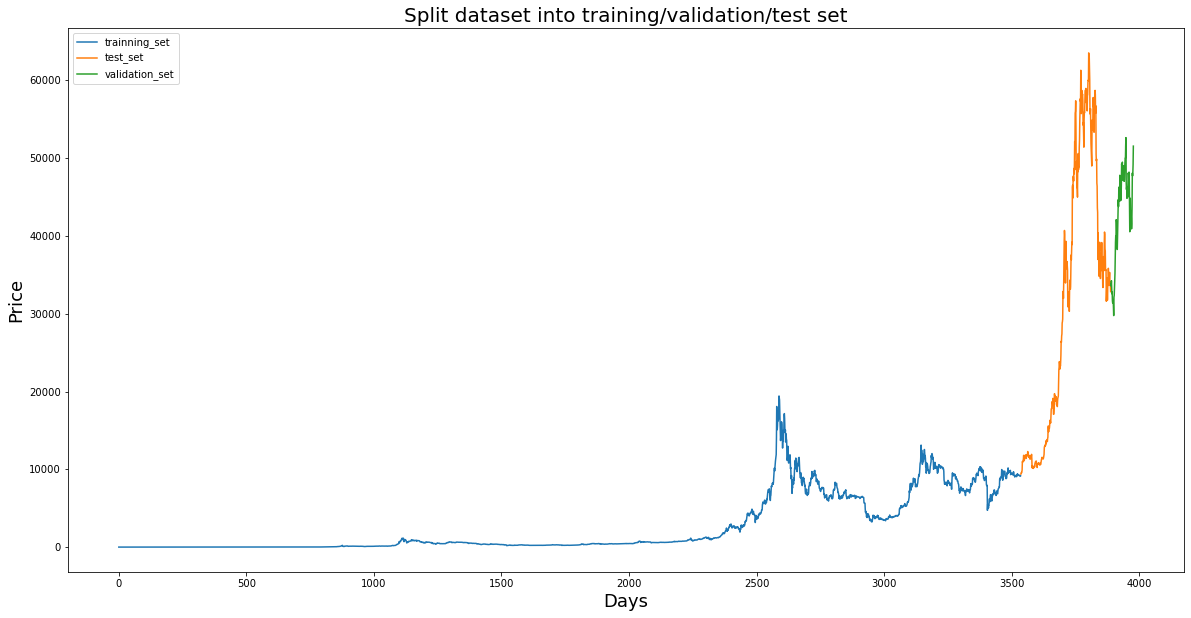

In [31]:

DataSet_Graph()

## Model Validation

# Getting the RMSE and R2 score by predicting the model.
# DTR model RMSE and R2 score with plot

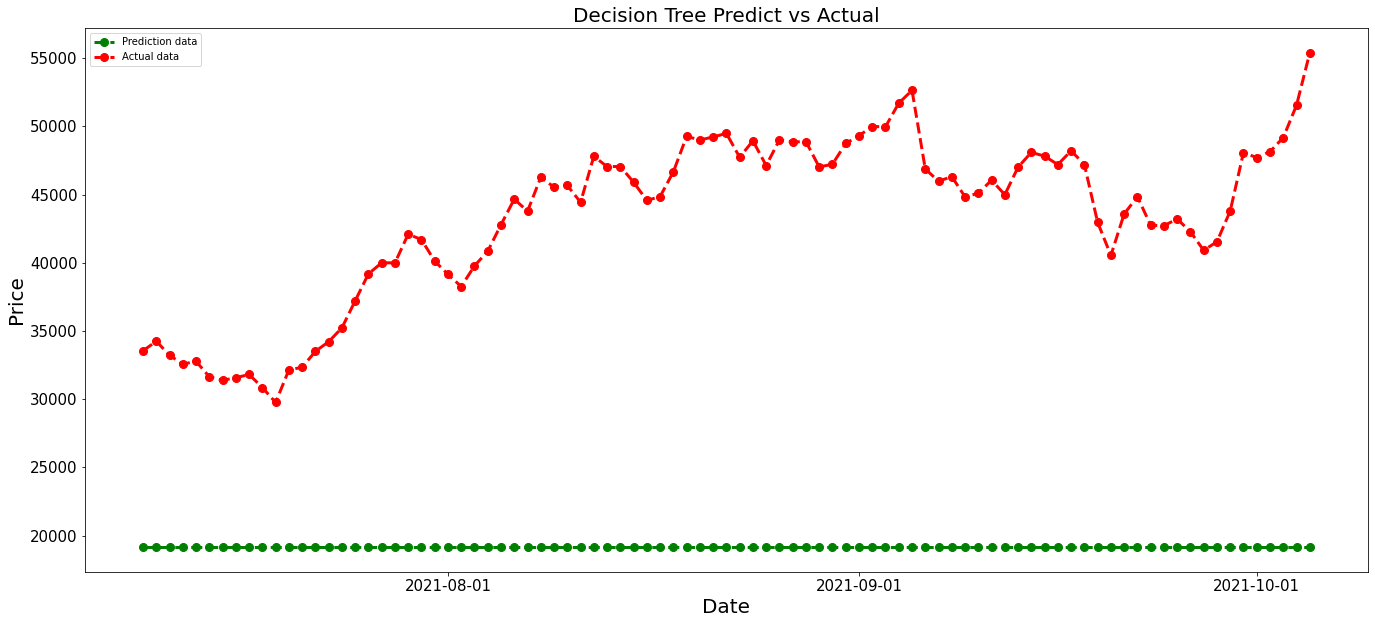

Decision Tree RMSE:  24906.750023617195
Decision Tree R2 score:  -15.936794099809806


In [32]:

RMSE_Score, R2_Score = model_validateResult(model_Decision_Tree_Regressor, model_name = "Decision Tree")

## Solution Model Validation
## SVR Model

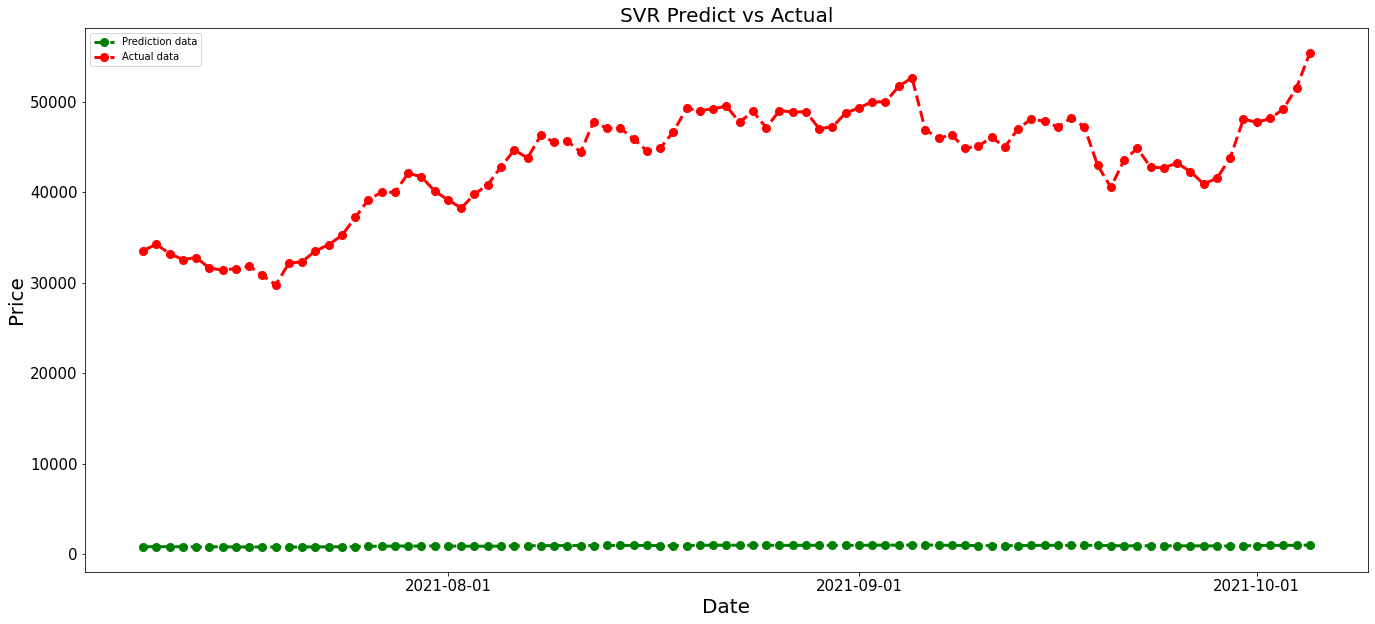

SVR RMSE:  42789.354648060165
SVR R2 score:  -48.98832178851561


In [33]:

RMSE_Score, R2_Score = model_validateResult(model_SVR, model_name = "SVR")




# SVR model Tuning

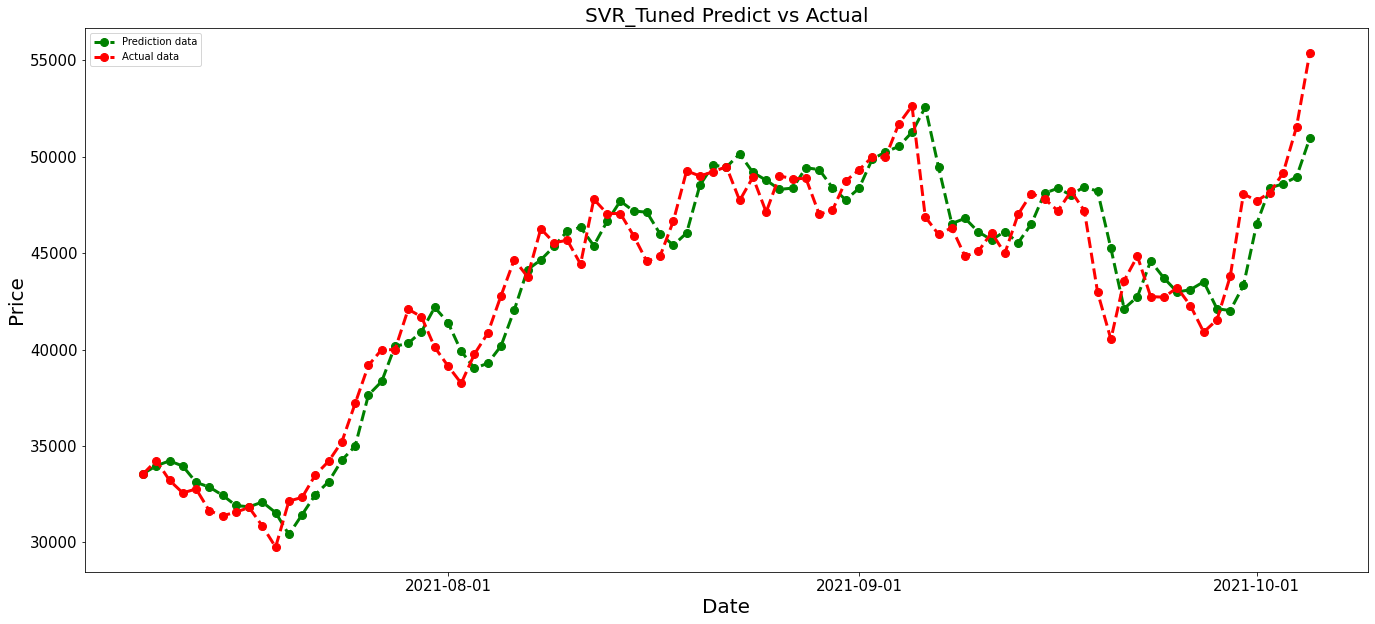

SVR_Tuned RMSE:  1827.5272339705784
SVR_Tuned R2 score:  0.9088147067702512


In [35]:

RMSE_Score, R2_Score = model_validateResult(model_SVRTuning, model_name = "SVR_Tuned")


## Lasso and Ridge Model

RMSE_Score, R2_Score = model_validateResult(model_Lasso, model_name = "Lasso")
RMSE_Score, R2_Score = model_validateResult(model_Ridge, model_name = "Ridge")

## Which one is the Best Model?

In [36]:
def ValidationDataResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    args:
        model : it takes the model to validate
        model_name: give the model name
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """
    model = model(x_train, y_train, validation_x)
    prediction = model.predict(validation_x)
    
    RMSE_Score = np.sqrt(mean_squared_error(validation_y, prediction))
    
    R2_Score = r2_score(validation_y, prediction)
    
    model_validation = {model_name:[RMSE_Score,R2_Score]}
    return model_validation


################################################################################


#Method to evaluate the final model with testing data set
def TestDataResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    USing testing data set for evaluation
    args:
        model : it takes the model to validate
        model_name: give the model name
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """
    
    # Testing set for the evaluation 
    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)
    
    RMSE_Score = np.sqrt(mean_squared_error(y_test, prediction))
    
    R2_Score = r2_score(y_test, prediction)
    
    model_validation_test_data = {model_name:[RMSE_Score,R2_Score]}
    
    return model_validation_test_data

In [37]:
import warnings
warnings.filterwarnings('ignore')

model_list = {'Decision_Tree': model_Decision_Tree_Regressor,'SVR': model_SVR,
              'SVR_Tuning':model_SVRTuning, 'Lasso':model_Lasso,'Ridge':model_Ridge}


ValidationData_RMSE_R2_Score = []
TestData_RMSE_R2_Score = []


for key, value in model_list.items():
    all_model_val = ValidationDataResult(model = value, model_name = key)
    ValidationData_RMSE_R2_Score.append(all_model_val)
print('Validation Data Result : ',ValidationData_RMSE_R2_Score)



for key, value in model_list.items():
    all_model_val_test = TestDataResult(model = value, model_name = key)
    TestData_RMSE_R2_Score.append(all_model_val_test)
print('Test Data Result : ', TestData_RMSE_R2_Score)

Validation Data Result :  [{'Decision_Tree': [24906.750023617195, -15.936794099809806]}, {'SVR': [42789.354648060165, -48.98832178851561]}, {'SVR_Tuning': [1827.5272339705784, 0.9088147067702512]}, {'Lasso': [1625.8226703962516, 0.9278322053639307]}, {'Ridge': [1792.5080992748271, 0.9122758159885486]}]
Test Data Result :  [{'Decision_Tree': [20566.19342358244, -0.39266686315495636]}, {'SVR': [34681.12517499373, -2.960278867017442]}, {'SVR_Tuning': [752.8433490384618, 0.9981338409889566]}, {'Lasso': [63.971342563497004, 0.9999865255719145]}, {'Ridge': [689.112738163887, 0.9984364205066413]}]


In [38]:
RMSE_ValidationData,R2_Score_ValidationData,models_ValidationData = [],[],[]

for i in ValidationData_RMSE_R2_Score:
    for key,value in i.items():
        RMSE_ValidationData.append(value[0])
        R2_Score_ValidationData.append(value[1])
        models_ValidationData.append(key)
        


RMSE_TestData,R2_Score_TestData,models_TestData= [],[],[]

for i in TestData_RMSE_R2_Score:
    for key,value in i.items():
        RMSE_TestData.append(value[0])
        R2_Score_TestData.append(value[1])
        models_TestData.append(key)

    
    
Validation_Model_List = pd.DataFrame(np.column_stack([RMSE_ValidationData,R2_Score_ValidationData]), index = models_ValidationData,columns = ['RMSE','R2_Score'] )
Test_Model_List = pd.DataFrame(np.column_stack([RMSE_TestData,R2_Score_TestData]), index = models_TestData,columns = ['RMSE','R2_Score'] )

In [39]:
Validation_Model_List

,RMSE,R2_Score
Decision_Tree,24906.750024,-15.936794
SVR,42789.354648,-48.988322
SVR_Tuning,1827.527234,0.908815
Lasso,1625.822670,0.927832
Ridge,1792.508099,0.912276


In [40]:
Test_Model_List

,RMSE,R2_Score
Decision_Tree,20566.193424,-0.392667
SVR,34681.125175,-2.960279
SVR_Tuning,752.843349,0.998134
Lasso,63.971343,0.999987
Ridge,689.112738,0.998436


In [41]:


# We select lowest RMSE and Highest R2_Score to select best Model.All results indicate SVR_Tuning is the best model.
print('Min RMSE for Validation DataSet : ', Validation_Model_List['RMSE'].idxmin(),'\nMax R2_Score for Validation DataSet : ',Validation_Model_List['R2_Score'].idxmax())
print('Min RMSE for Test DataSet: ',Test_Model_List['RMSE'].idxmin(),'\nMax R2_Score for Test DataSet : ',Test_Model_List['R2_Score'].idxmax())



Min RMSE for Validation DataSet :  Lasso 
Max R2_Score for Validation DataSet :  Lasso
Min RMSE for Test DataSet:  Lasso 
Max R2_Score for Test DataSet :  Lasso


## SVR_Tuning

# Based on the RSME Scroe and R2 Score, I am selecting SVR with tuned model as best model for this. 
# Below I am going predict the value with test df
# SVR_Tuning model validation with test data

SVR_Best Model  RMSE:  752.8433490384618
SVR_Best Model  R2 score:  0.9981338409889566


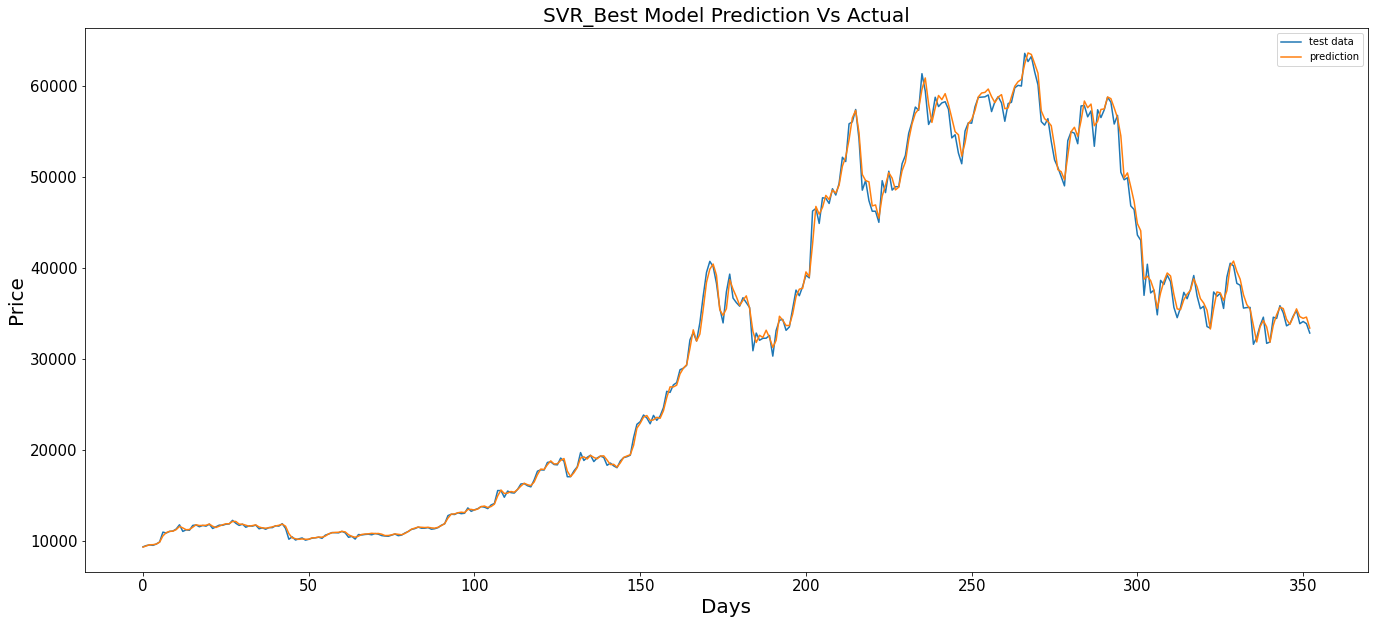

In [42]:

RMSE_Score, R2_Score = bestModel_validateResult(model_SVRTuning, model_name = "SVR_Best Model ")

# SVR_Tuned model actual vs prected value

In [43]:

prediction_df = value_Compare(model_SVRTuning)
display(prediction_df.tail(40))


,True_value,Predicted_value
313,35618.16,35401.132176
314,37303.75,36488.690969
315,36606.39,37110.614980
316,37622.43,37520.307617
317,39152.71,38788.497801
318,36908.14,37914.221497
319,35510.26,36622.719172
320,35781.01,36126.791939
321,33550.00,35338.505507
322,33369.14,33281.077045


## Prediction Graph

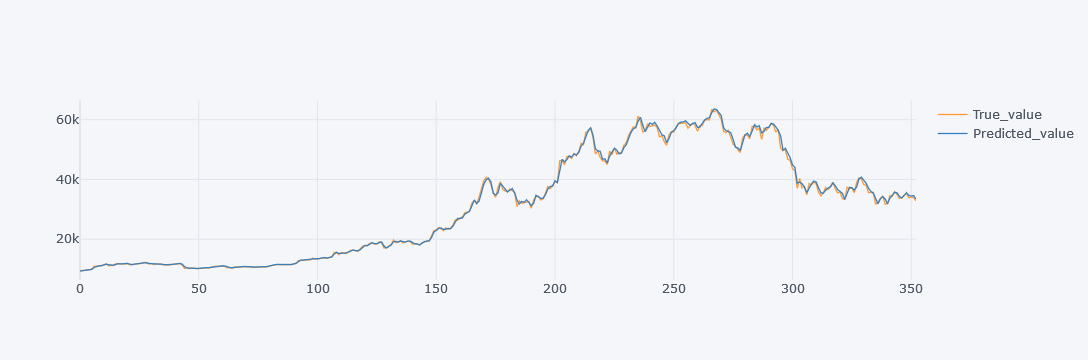

In [44]:
prediction_df.iplot()